In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print(tf.__version__)

2.1.0


In [2]:
dataset_path = os.path.join("dataset", "35288-STMALO-Statistiques-Web-Quotidien.csv")
df = pd.read_csv(dataset_path, sep=";")
df.head()

,Jour,Visites,Visiteurs uniques,Pages vues
0,01/01/2012,906,807,2184
1,02/01/2012,1655,1404,4234
2,03/01/2012,1728,1484,4574
3,04/01/2012,1604,1370,4123
4,05/01/2012,1885,1578,4663


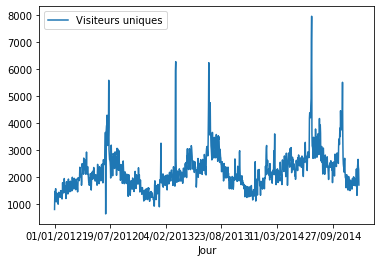

In [3]:
df.plot("Jour", "Visiteurs uniques")

In [4]:
def normalize_series(series):
    mean_series = np.mean(series)
    max_series = np.max(series)
    normalized_series = (series - mean_series)/max_series
    return normalized_series, mean_series, max_series

In [5]:
def unnormalize_series(series, mean_series, max_series):
    return series*max_series + mean_series

In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
series = np.array(df["Visites"])
dates = df["Jour"]
len_time = len(dates)
time = np.arange(len_time)
split_time = int(len_time*0.7)

print("There are {} days in the dataset.".format(len_time))
print("Split time : {}".format(split_time))

# Normalize series
series, mean_series, max_series  = normalize_series(series)

# Train/Validation split
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

There are 1096 days in the dataset.
Split time : 767


In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)

window_size = 16
batch_size = 128
shuffle_buffer_size = 2000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="same",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dense(32),
  tf.keras.layers.Dense(1, activation="tanh"),
  tf.keras.layers.Lambda(lambda x: x * 2)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=5.e-5)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=400)

Epoch 1/400
6/6 [==============================] - 3s 511ms/step - loss: 0.0038 - mae: 0.0621
Epoch 2/400
6/6 [==============================] - 0s 26ms/step - loss: 0.0034 - mae: 0.0567
Epoch 3/400
6/6 [==============================] - 0s 26ms/step - loss: 0.0030 - mae: 0.0528
Epoch 4/400
6/6 [==============================] - 0s 27ms/step - loss: 0.0026 - mae: 0.0491
Epoch 5/400
6/6 [==============================] - 0s 31ms/step - loss: 0.0023 - mae: 0.0442
Epoch 6/400
6/6 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.041 - 0s 34ms/step - loss: 0.0021 - mae: 0.0414
Epoch 7/400
6/6 [==============================] - 0s 29ms/step - loss: 0.0020 - mae: 0.0394
Epoch 8/400
6/6 [==============================] - 0s 26ms/step - loss: 0.0019 - mae: 0.0384
Epoch 9/400
6/6 [==============================] - 0s 31ms/step - loss: 0.0018 - mae: 0.0378
Epoch 10/400
6/6 [==============================] - 0s 39ms/step - loss: 0.0018 - mae: 0.0375
Epoch 11/400
6/6 [============

6/6 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0302
Epoch 88/400
6/6 [==============================] - 0s 21ms/step - loss: 0.0012 - mae: 0.0300
Epoch 89/400
6/6 [==============================] - 0s 21ms/step - loss: 0.0012 - mae: 0.0299
Epoch 90/400
6/6 [==============================] - 0s 26ms/step - loss: 0.0012 - mae: 0.0299
Epoch 91/400
6/6 [==============================] - 0s 25ms/step - loss: 0.0012 - mae: 0.0305
Epoch 92/400
6/6 [==============================] - 0s 25ms/step - loss: 0.0012 - mae: 0.0301
Epoch 93/400
6/6 [==============================] - 0s 25ms/step - loss: 0.0012 - mae: 0.0310
Epoch 94/400
6/6 [==============================] - 0s 29ms/step - loss: 0.0012 - mae: 0.0300
Epoch 95/400
6/6 [==============================] - 0s 25ms/step - loss: 0.0012 - mae: 0.0305
Epoch 96/400
6/6 [==============================] - 0s 24ms/step - loss: 0.0012 - mae: 0.0300
Epoch 97/400
6/6 [==============================] - 0s 28ms/step - loss: 

6/6 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0288
Epoch 174/400
6/6 [==============================] - 0s 40ms/step - loss: 0.0011 - mae: 0.0286
Epoch 175/400
6/6 [==============================] - 0s 38ms/step - loss: 0.0011 - mae: 0.0288
Epoch 176/400
6/6 [==============================] - 0s 26ms/step - loss: 0.0011 - mae: 0.0285
Epoch 177/400
6/6 [==============================] - 0s 38ms/step - loss: 0.0011 - mae: 0.0288
Epoch 178/400
6/6 [==============================] - 0s 43ms/step - loss: 0.0011 - mae: 0.0289
Epoch 179/400
6/6 [==============================] - 0s 23ms/step - loss: 0.0012 - mae: 0.0286
Epoch 180/400
6/6 [==============================] - 0s 28ms/step - loss: 0.0011 - mae: 0.0289
Epoch 181/400
6/6 [==============================] - 0s 26ms/step - loss: 0.0011 - mae: 0.0285
Epoch 182/400
6/6 [==============================] - 0s 32ms/step - loss: 0.0012 - mae: 0.0287
Epoch 183/400
6/6 [==============================] - 0s 24ms/ste

6/6 [==============================] - 0s 23ms/step - loss: 0.0011 - mae: 0.0279
Epoch 259/400
6/6 [==============================] - 0s 28ms/step - loss: 0.0011 - mae: 0.0283
Epoch 260/400
6/6 [==============================] - 0s 30ms/step - loss: 0.0011 - mae: 0.0278
Epoch 261/400
6/6 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0293
Epoch 262/400
6/6 [==============================] - 0s 29ms/step - loss: 0.0011 - mae: 0.0281
Epoch 263/400
6/6 [==============================] - 0s 23ms/step - loss: 0.0011 - mae: 0.0291
Epoch 264/400
6/6 [==============================] - 0s 22ms/step - loss: 0.0011 - mae: 0.0281
Epoch 265/400
6/6 [==============================] - 0s 26ms/step - loss: 0.0011 - mae: 0.0287
Epoch 266/400
6/6 [==============================] - 0s 20ms/step - loss: 0.0011 - mae: 0.0280
Epoch 267/400
6/6 [==============================] - 0s 26ms/step - loss: 0.0011 - mae: 0.0276
Epoch 268/400
6/6 [==============================] - 0s 27ms/ste

6/6 [==============================] - 0s 26ms/step - loss: 0.0011 - mae: 0.0290
Epoch 345/400
6/6 [==============================] - 0s 22ms/step - loss: 0.0011 - mae: 0.0281
Epoch 346/400
6/6 [==============================] - 0s 24ms/step - loss: 0.0010 - mae: 0.0274
Epoch 347/400
6/6 [==============================] - 0s 27ms/step - loss: 0.0010 - mae: 0.0271
Epoch 348/400
6/6 [==============================] - 0s 23ms/step - loss: 0.0011 - mae: 0.0282
Epoch 349/400
6/6 [==============================] - 0s 26ms/step - loss: 0.0010 - mae: 0.0278
Epoch 350/400
6/6 [==============================] - 0s 25ms/step - loss: 0.0011 - mae: 0.0271
Epoch 351/400
6/6 [==============================] - 0s 27ms/step - loss: 0.0011 - mae: 0.0286
Epoch 352/400
6/6 [==============================] - 0s 30ms/step - loss: 0.0010 - mae: 0.0274
Epoch 353/400
6/6 [==============================] - 0s 34ms/step - loss: 0.0011 - mae: 0.0283
Epoch 354/400
6/6 [==============================] - 0s 39ms/ste

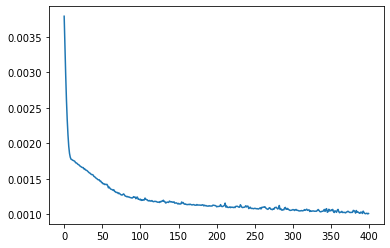

In [17]:
plt.plot(np.arange(len(history.history["loss"])), history.history["loss"])

MAE : 0.0329529270529747


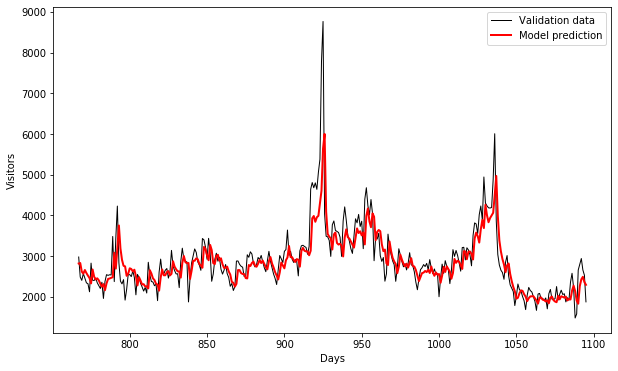

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plt.plot(time_valid, unnormalize_series(x_valid, mean_series, max_series), "k", linewidth=1, label="Validation data")
plt.plot(time_valid, unnormalize_series(rnn_forecast, mean_series, max_series), "r", linewidth=2, label="Model prediction")
plt.xlabel("Days")
plt.ylabel("Visitors")
plt.legend()

print("MAE : {}".format(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()))